# Executor Data Overhead

In [1]:
from __future__ import annotations

import importlib
import json
import os
import pathlib

import seaborn
import polars
from matplotlib import pyplot as plt

polars.Config.set_tbl_rows(100)

polars.config.Config

In [2]:
def load_tasks(filepath: pathlib.Path) -> polars.DataFrame:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            if task_info['function_name'] == 'noop_task':
                execution_info = task_info.pop('execution')
                task_info = {**task_info, **execution_info}
                tasks.append(task_info)

    return polars.DataFrame(tasks)

def get_info_from_log(filepath: pathlib.Path) -> dict:
    with open(filepath) as f:
        for line in f.readlines():
            if "name='synthetic'" in line:
                config = line
                break

    for term in config.split(' '):
        if 'task_data_bytes' in term:
            size = int(term.split('=')[1][:-1])
            break
    else:
        raise ValueError('Size not found')

    for term in config.split(' '):
        if 'task_count' in term:
            count = int(term.split('=')[1][:-1])
            break
    else:
        raise ValueError('Size not found')
    
    if "NullTransformerConfig" in config:
        transformer = "Baseline (None)"
    elif "PickleFileTransformerConfig" in config:
        transformer = "File"
    elif "ProxyFileTransformerConfig" in config:
        if "ps_type='file'" in config:
            transformer = "ProxyStore (File)"
        elif "ps_type='redis'" in config:
            transformer = "ProxyStore (Redis)"
    else:
        raise ValueError(config)

    return {'transformer': transformer, 'size': size, 'count': count}
    

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.json'):
        app, executor, timestamp = str(tasks_path.relative_to(directory).parent).split('/')
        
        tasks = load_tasks(tasks_path)
        start_time = tasks['submit_time'].min()
        end_time = tasks['received_time'].max()

        info = get_info_from_log(tasks_path.parent / 'log.txt')
        task_time = end_time - start_time

        run_info = {
            'app': app,
            'executor': executor,
            'timestamp': timestamp,
            'transformer': info['transformer'],
            'data-size-bytes': info['size'],
            'task-count': info['count'],
            'total-time': task_time,
            'avg-task-time-ms': 1000 * task_time / info['count']
        }
        runs.append(run_info)
    
        # run_info = {
        #     'app': app,
        #     'executor': executor,
        #     'timestamp': timestamp,
        #     'type': 'overhead',
        #     'time': app_time - task_time,
        # }
        # runs.append(run_info)
        # run_info = {
        #     'app': app,
        #     'executor': executor,
        #     'timestamp': timestamp,
        #     'type': 'execution',
        #     'time': task_time,
        # }
        # runs.append(run_info)

    return polars.DataFrame(runs)

In [12]:
data = load_data(pathlib.Path('../runs/data/'))
data

app,executor,timestamp,transformer,data-size-bytes,task-count,total-time,avg-task-time-ms
str,str,str,str,i64,i64,f64,f64
"""synthetic""","""process-pool""","""2024-05-26-21-20-46""","""Baseline (None)""",100000,10,0.014209,1.420927
"""synthetic""","""process-pool""","""2024-05-26-21-21-45""","""ProxyStore (File)""",100000,10,0.023471,2.347136
"""synthetic""","""process-pool""","""2024-05-26-21-21-38""","""ProxyStore (File)""",10000,10,0.016778,1.677775
"""synthetic""","""process-pool""","""2024-05-26-21-21-53""","""ProxyStore (File)""",1000000,10,0.085563,8.556342
"""synthetic""","""process-pool""","""2024-05-26-21-22-14""","""ProxyStore (Redis)""",10000000,10,0.960394,96.039414
"""synthetic""","""process-pool""","""2024-05-26-21-21-51""","""ProxyStore (File)""",1000000,10,0.085115,8.511543
"""synthetic""","""process-pool""","""2024-05-26-21-20-38""","""Baseline (None)""",10000,10,0.009217,0.921679
"""synthetic""","""process-pool""","""2024-05-26-22-40-17""","""ProxyStore (Redis)""",10000,10,0.01691,1.691008
"""synthetic""","""process-pool""","""2024-05-26-22-40-29""","""ProxyStore (Redis)""",1000000,10,0.099445,9.944487


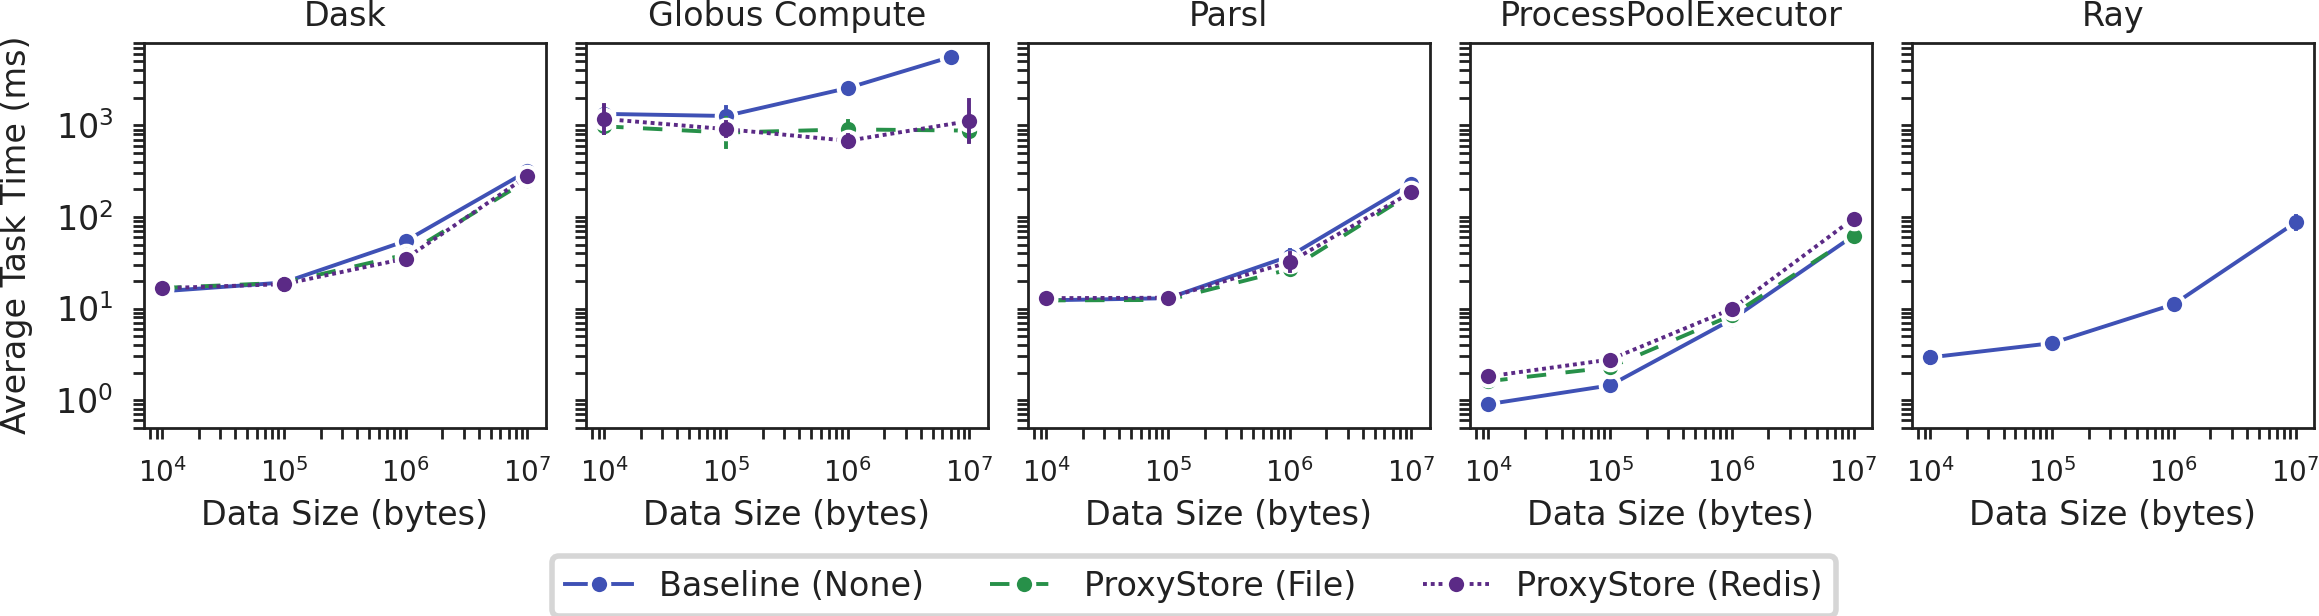

In [29]:
rows, cols = 1, 5
fig, axes = plt.subplots(rows, cols, sharey=True)
executors = sorted(set(data['executor']))
transformers = sorted(set(data['transformer']))
names = {
    'dask': 'Dask',
    'globus-compute': 'Globus Compute',
    'parsl': 'Parsl',
    'process-pool': 'ProcessPoolExecutor',
    'ray': 'Ray',
}
colors = {executor: color['color'] for executor, color in zip(executors, plt.rcParams['axes.prop_cycle'])}
colors = {
    'Baseline (None)': '#000000',
    'ProxyStore (File)': '#F89438',
    'ProxyStore (Redis)': '#2D5D91',
}
dashes = {
    'Baseline (None)': (),
    'ProxyStore (File)': (5, 5),
    'ProxyStore (Redis)': (1, 1),
}
markers = {
    'Baseline (None)': 'o',
    'ProxyStore (File)': 'o',
    'ProxyStore (Redis)': 'o',
}

for x in range(cols):
    if x >= len(executors):
        continue
    executor = executors[x]

    subdata = data.filter(polars.col('executor') == executor)
    ax = axes[x]
    seaborn.lineplot(
        ax=ax,
        data=subdata,
        hue_order=transformers,
        y='avg-task-time-ms',
        x='data-size-bytes',
        hue='transformer',
        style='transformer',
        errorbar='sd',
        err_style='bars',
        # palette=colors,
        dashes=dashes,
        markers=markers,
    )
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(names[executor], pad=3)
    ax.set_ylabel('Average Task Time (ms)')
    ax.tick_params(axis='x', labelsize=5)
    ax.set_xlabel('Data Size (bytes)', labelpad=2)
            
    # ax.set_yticks(range(len(executors)))
    # ax.set_yticklabels([names[name] for name in executors])
    # l, r = ax.get_xlim()
    # ax.set_xlim(l * 1.05, r * 1.05)

    if executor == 'parsl':
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.3))
    ax.get_legend().remove()
    ax.set_ylim([0.5, 8000])

# TODO: baseline as black dashed line, change colors, use markers with stdev
plt.subplots_adjust(wspace=0.1, hspace=0.5)
fig.set_size_inches(7, 1.25)
plt.savefig('../figures/data-transformers.pdf', pad_inches=0.05)

In [34]:
data.group_by(['app', 'executor', 'transformer', 'data-size-bytes']).mean().sort('app', 'executor', 'data-size-bytes', 'transformer').select('executor', 'data-size-bytes', 'transformer', 'avg-task-time-ms')

executor,data-size-bytes,transformer,avg-task-time-ms
str,i64,str,f64
"""dask""",10000,"""Baseline (None)""",15.419904
"""dask""",10000,"""ProxyStore (File)""",16.769083
"""dask""",10000,"""ProxyStore (Redis)""",16.673748
"""dask""",100000,"""Baseline (None)""",19.257092
"""dask""",100000,"""ProxyStore (File)""",19.10793
"""dask""",100000,"""ProxyStore (Redis)""",18.448218
"""dask""",1000000,"""Baseline (None)""",54.654074
"""dask""",1000000,"""ProxyStore (File)""",38.836145
"""dask""",1000000,"""ProxyStore (Redis)""",35.145656
